In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import os, sys
import itertools, functools
import numpy as np
import pandas as pd
import tensorflow as tf

import h5py
from skimage.io import imread, imshow
from skimage.transform import resize
from keras.models import Model
from keras.layers import Input
from keras.layers.core import Dense, Dropout, Reshape, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

DATASET = lambda fname = '': os.path.join('B:/TransferLearning', fname)
assert os.path.exists(DATASET())

class DogsVsCats(Model):
    def __init__(self):
        self.images = Input(shape = [150, 150, 3])
        self.vgg16 = VGG16(weights = None, include_top = False)
        classifier = [
            Flatten(input_shape = self.vgg16.output_shape[1:]),
            Dense(256, activation='relu'),
            Dropout(0.5),
            Dense(1, activation='sigmoid'),
        ]
        self.prediction = functools.reduce(lambda f1, f2: f2(f1), [self.images, self.vgg16]+classifier)
        super(DogsVsCats, self).__init__(
            inputs = [self.images],
            outputs = [self.prediction]
        )
        self.compile(loss='binary_crossentropy',
            optimizer=SGD(lr=1e-4, momentum=0.9),
            metrics=['accuracy'])

    def freeze_vgg16(trainable = False):
        for layer in self.vgg16.layers:
            layer.trainable = trainable

if 0:
    model = DogsVsCats()
    model.load_weights(DATASET('weights_dogs_cats.h5'))

    BATCH_SIZE = 20
    test_datagen = ImageDataGenerator(rescale = 1. / 255)
    validation_generator = test_datagen.flow_from_directory(
        DATASET('TransferLearning/validation'),
        target_size=(150, 150),
        batch_size=BATCH_SIZE,
        class_mode='binary')

    loss, accuracy = model.evaluate_generator(validation_generator, steps = 800 // BATCH_SIZE)
    print('loss:', loss, 'accuracy:', accuracy)

model = VGG16(weights = None, include_top = False)
last_layer = None
with h5py.File(DATASET('weights_dogs_cats.h5')) as f:
    vgg16_weights = f['vgg16']
    for name in vgg16_weights:
        print('Loading weights for', name)
        weights = list(map(lambda pname:np.array(vgg16_weights[name][pname]), ['kernel:0', 'bias:0']))
        last_layer = model.get_layer(name)
        last_layer.set_weights(weights)

im_test = imread(DATASET('TransferLearning/validation/cats/14.jpg'))
im_test = resize(im_test, (150, 150), mode = 'reflect')
y_features = model.predict(np.expand_dims(im_test, 0))
kernels = np.transpose(last_layer.get_weights()[0], (2,3,0,1)).reshape((-1,9))
print('kernel_shape', kernels.shape)
print('feature_shape', y_features.shape)

Using TensorFlow backend.


Loading weights for block1_conv1
Loading weights for block1_conv2
Loading weights for block2_conv1
Loading weights for block2_conv2
Loading weights for block3_conv1
Loading weights for block3_conv2
Loading weights for block3_conv3
Loading weights for block4_conv1
Loading weights for block4_conv2
Loading weights for block4_conv3
Loading weights for block5_conv1
Loading weights for block5_conv2
Loading weights for block5_conv3
kernel_shape (262144, 9)
feature_shape (1, 4, 4, 512)


In [2]:
kernels_subset = np.array(pd.DataFrame(kernels).sample(n=8000))
print(kernels_subset.shape)

(8000, 9)


In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=2000)
tsne_results = tsne.fit_transform(kernels_subset)
print(tsne_results.shape)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 8000 samples in 0.007s...
[t-SNE] Computed neighbors for 8000 samples in 0.793s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8000
[t-SNE] Computed conditional probabilities for sample 2000 / 8000
[t-SNE] Computed conditional probabilities for sample 3000 / 8000
[t-SNE] Computed conditional probabilities for sample 4000 / 8000
[t-SNE] Computed conditional probabilities for sample 5000 / 8000
[t-SNE] Computed conditional probabilities for sample 6000 / 8000
[t-SNE] Computed conditional probabilities for sample 7000 / 8000
[t-SNE] Computed conditional probabilities for sample 8000 / 8000
[t-SNE] Mean sigma: 0.003559
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.850594


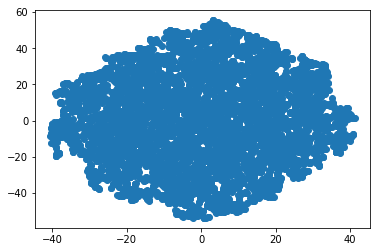

In [7]:
plt.scatter(tsne_results[:,0],tsne_results[:,1])

In [ ]:
tsne_results3 = TSNE(n_components=3, verbose=1, perplexity=15, n_iter=500).fit_transform(kernels_subset)
print(tsne_results.shape)